In [6]:
import itertools
import os
import subprocess

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

import torch

# set resolution of plt figures to 120
plt.rcParams['figure.dpi'] = 150
# Helvetica doesn't support up arrow unicode
#plt.rcParams['font.family'] = 'Helvetica'

from netam.framework import load_crepe
from netam import dnsm
from netam.sequences import translate_sequence, translate_sequences
from netam.common import pick_device
from dnsmex.dnsm_zoo import validation_burrito_of
from dnsmex.dnsm_zoo import create_model

device = pick_device()
if device.type == 'mps':
    print("Actually, using CPU")
    device = "cpu"

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

Using Metal Performance Shaders
Actually, using CPU


In [50]:
# https://www.rcsb.org/sequence/2VXS

igh_2vxs_with_constant = "EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDLIHGVTRNWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPQPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDKTH"

igh_2vxs = igh_2vxs_with_constant[:118]
igh_2vxs_f = model.selection_factors_of_aa_str(igh_2vxs).detach().numpy()
igh_2vxs

'EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDLIHGVTRNWGQGTLVTVSS'

In [51]:
# from Kevin: https://matsengrp.slack.com/archives/D016B9AU8KG/p1709159777832859
# https://www.imgt.org/IMGTrepertoire/Proteins/alleles/index.php?species=Homo%20sapiens&group=IGHV&gene=IGHV3-23 but adjusted to use 1-indexing
cdr_locations_2vxs = {
    'CDR1': (25, 33),
    'CDR2': (50, 58),
    'CDR3': (96, 107) 
}

cdr_regions_2vxs = {cdr: igh_2vxs[start:end] for cdr, (start, end) in cdr_locations_2vxs.items()}

cdr_regions_2vxs

{'CDR1': 'GFTFSSYA', 'CDR2': 'ISGSGGST', 'CDR3': 'ARDLIHGVTRN'}

In [ ]:
res_2vxs = ResultContainer(igh_2vxs, cdr_locations_2vxs, igh_2vxs_f, '2VXS')
res_2vxs.write_dms_viz_input_csvs()
res_2vxs.run_configure_dms_viz()

In [29]:
import pandas as pd

# From https://matsengrp.slack.com/archives/D016B9AU8KG/p1705595919821959
igh_df = pd.read_csv("../data/_ignore/ighv_aa.csv")

# make a dict of the igh_df with gene mapping to sequence
igh_dict = {}
for i, row in igh_df.iterrows():
    igh_dict[row["gene"]] = row["sequence"].replace("-", "")

# Get this file from the online data dump from McCoy et al.
mccoy_df = pd.read_csv("../data/_ignore/site_hpds.csv")



def sub_mccoy_df_for_subject(subject_name):
    sub_mccoy_df = mccoy_df[mccoy_df["subject"] == subject_name]
    sub_mccoy_df = sub_mccoy_df[sub_mccoy_df["gene"] == "IGHV3-23*01"]
    sub_mccoy_df = sub_mccoy_df[sub_mccoy_df["variable"] == "dNdS"]
    sub_mccoy_df = sub_mccoy_df[sub_mccoy_df["subset"] == "productive/out-of-frame"]
    sub_mccoy_df.drop(columns=["gene", "variable", "subset"], inplace=True)
    sub_mccoy_df.reset_index(inplace=True, drop=True)
    sub_mccoy_df["aa"] = list(igh_dict["IGHV3-23*01"])
    sub_mccoy_df["2vxs"] = list(igh_2vxs[:len(sub_mccoy_df)])
    (sub_mccoy_df["aa"] != sub_mccoy_df["2vxs"]).to_numpy().nonzero()[0]
    sub_mccoy_df["2vxs_f"] = res_2vxs.selection_factors[:len(sub_mccoy_df)]
    sub_mccoy_df = sub_mccoy_df[sub_mccoy_df["coverage"] > 100000]
    return sub_mccoy_df

sub_mccoy_df = sub_mccoy_df_for_subject("A")
sub_mccoy_df.head()

,subject,sample,site,imgt_site,median,hpdLower,hpdUpper,coverage,oof_coverage,aa,2vxs,2vxs_f
73,A,04-A-M,73,81,0.681937,0.613455,0.768117,102654.0,5467.0,N,N,0.436491
74,A,04-A-M,74,82,1.073024,0.928027,1.223261,110526.0,6081.0,S,S,0.299331
75,A,04-A-M,75,83,1.054546,0.895150,1.210046,115580.0,6604.0,K,K,0.677030
76,A,04-A-M,76,84,0.853138,0.768944,0.957280,119678.0,7153.0,N,N,0.622975
77,A,04-A-M,77,85,0.801964,0.745595,0.868284,121677.0,7619.0,T,T,0.495019


In [30]:
all_sub_mccoy_df = pd.concat([sub_mccoy_df_for_subject(subject) for subject in mccoy_df["subject"].unique()])

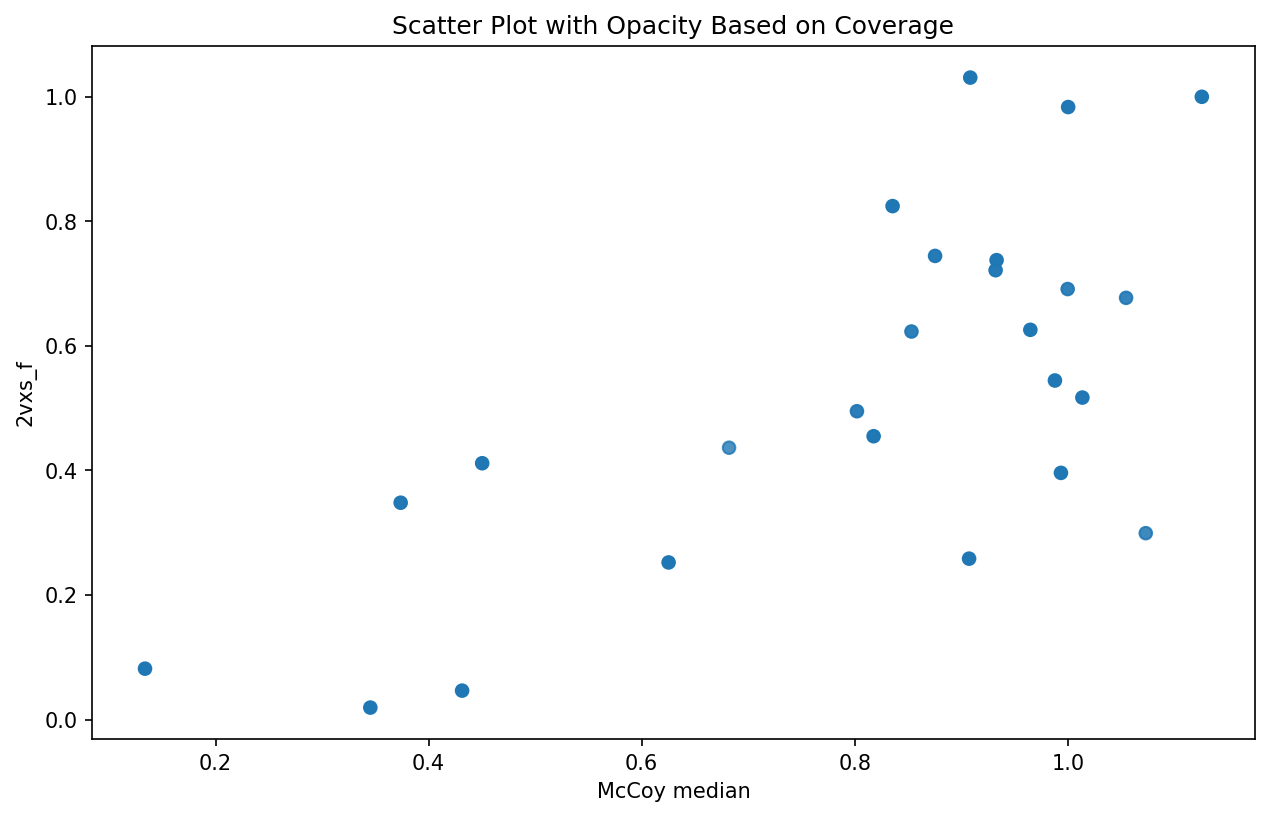

In [31]:

max_coverage = sub_mccoy_df['coverage'].max()
sub_mccoy_df['opacity'] = sub_mccoy_df['coverage'] / max_coverage

plt.figure(figsize=(10, 6))
plt.scatter(sub_mccoy_df['median'], sub_mccoy_df['2vxs_f'], alpha=sub_mccoy_df['opacity'])
plt.xlabel('McCoy median')
plt.ylabel('2vxs_f')
plt.title('Scatter Plot with Opacity Based on Coverage')
plt.show()

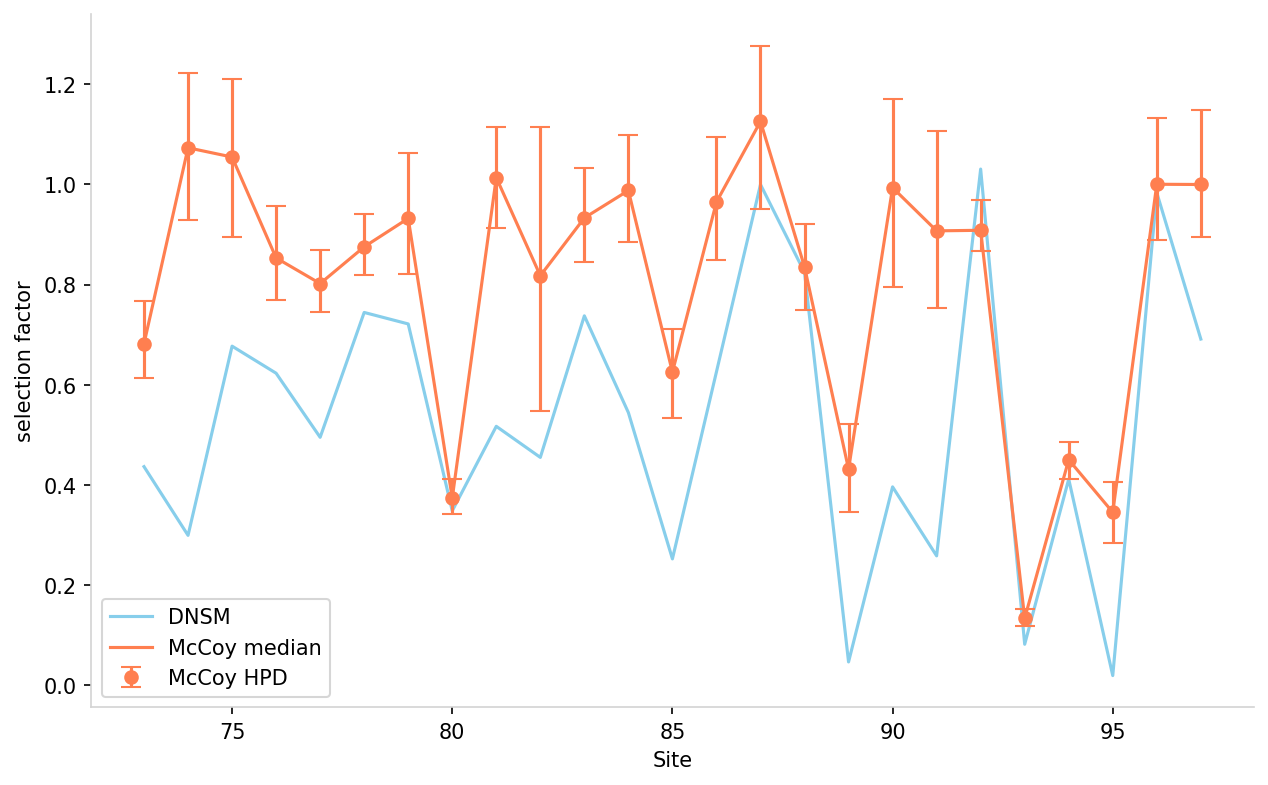

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Plotting
plt.figure(figsize=(10, 6))

# Plotting 2vxs_f
plt.plot(sub_mccoy_df['site'], sub_mccoy_df['2vxs_f'], label='DNSM', color='skyblue')
plt.plot(sub_mccoy_df['site'], sub_mccoy_df['median'], label='McCoy median', color='coral')

# Plotting median with hpdLower and hpdUpper as whiskers
plt.errorbar(sub_mccoy_df['site'], sub_mccoy_df['median'], 
             yerr=[sub_mccoy_df['median'] - sub_mccoy_df['hpdLower'], 
                   sub_mccoy_df['hpdUpper'] - sub_mccoy_df['median']],
             fmt='o', capsize=5, label='McCoy HPD', color='coral')

# Adding labels and title
plt.xlabel('Site')
plt.ylabel('selection factor')
plt.legend()

# Removing the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Setting a light grey for the remaining spines
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().spines['bottom'].set_color('lightgrey')

plt.savefig(figures_dir + 'agreement-dnsm-mccoy.svg', format='svg', dpi=1200, bbox_inches='tight')

# Show the plot
plt.show()




In [33]:
asa_df = pd.read_csv("../data/2VXS_asa.csv", index_col=0)

# AAs match except for the last one
(asa_df.loc[sub_mccoy_df.index, "site_aa"] != sub_mccoy_df["aa"]).to_numpy().nonzero()[0]
sub_mccoy_df["asa"] = asa_df.loc[sub_mccoy_df.index, "rel_asa_authH"]

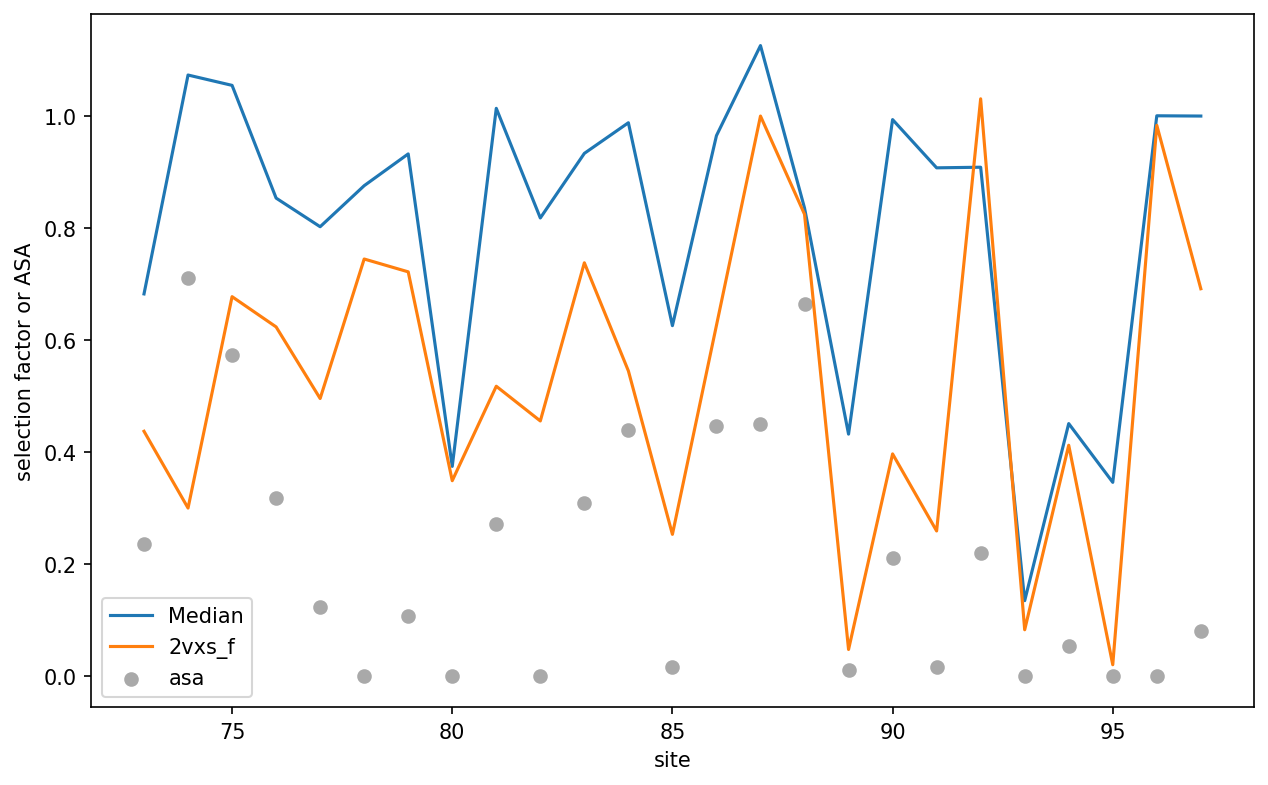

In [34]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sub_mccoy_df.index, sub_mccoy_df['median'], label='Median')
plt.plot(sub_mccoy_df.index, sub_mccoy_df['2vxs_f'], label='2vxs_f')
plt.scatter(sub_mccoy_df.index, sub_mccoy_df['asa'], label='asa', color='darkgray')

plt.xlabel('site')
plt.ylabel('selection factor or ASA')
plt.legend()

# Show the plot
plt.show()

Correlation of asa vs 2vxs_f: 0.3523346290449092
Correlation of asa vs median: 0.5598607676685322


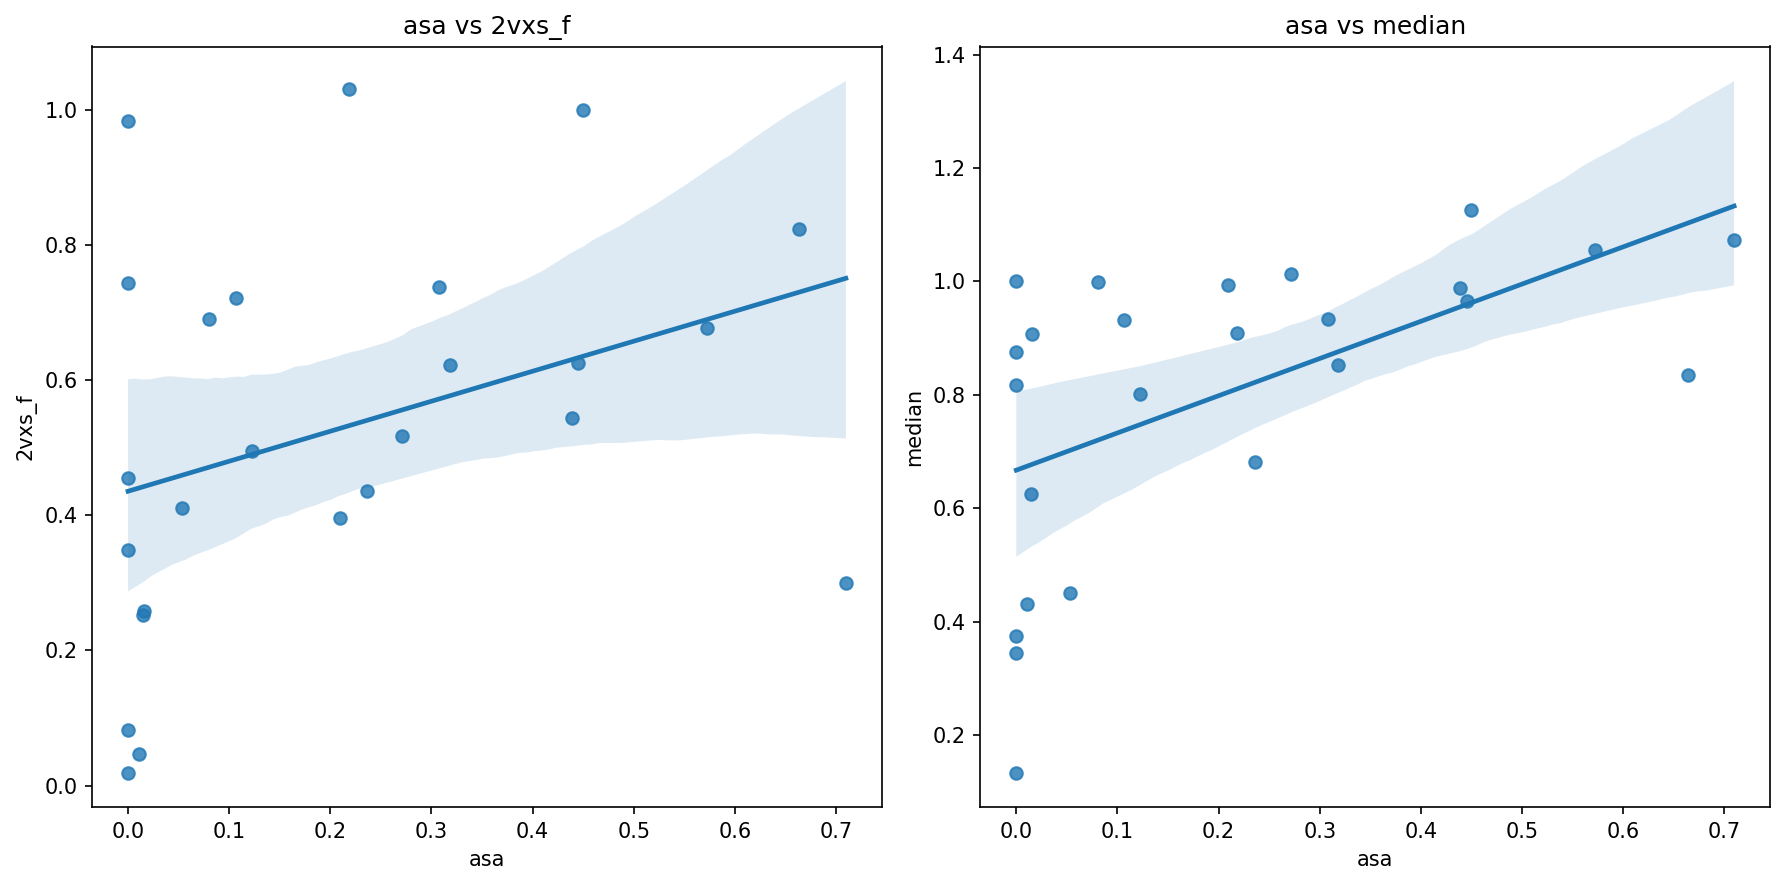

In [35]:
# Calculate correlation coefficients
corr_asa_2vxs_f = sub_mccoy_df['asa'].corr(sub_mccoy_df['2vxs_f'])
corr_asa_median = sub_mccoy_df['asa'].corr(sub_mccoy_df['median'])

print(f"Correlation of asa vs 2vxs_f: {corr_asa_2vxs_f}")
print(f"Correlation of asa vs median: {corr_asa_median}")

# Plotting
plt.figure(figsize=(12, 6))

# asa vs 2vxs_f
plt.subplot(1, 2, 1)
sns.regplot(x='asa', y='2vxs_f', data=sub_mccoy_df)
plt.title('asa vs 2vxs_f')

# asa vs median
plt.subplot(1, 2, 2)
sns.regplot(x='asa', y='median', data=sub_mccoy_df)
plt.title('asa vs median')

plt.tight_layout()
plt.show()

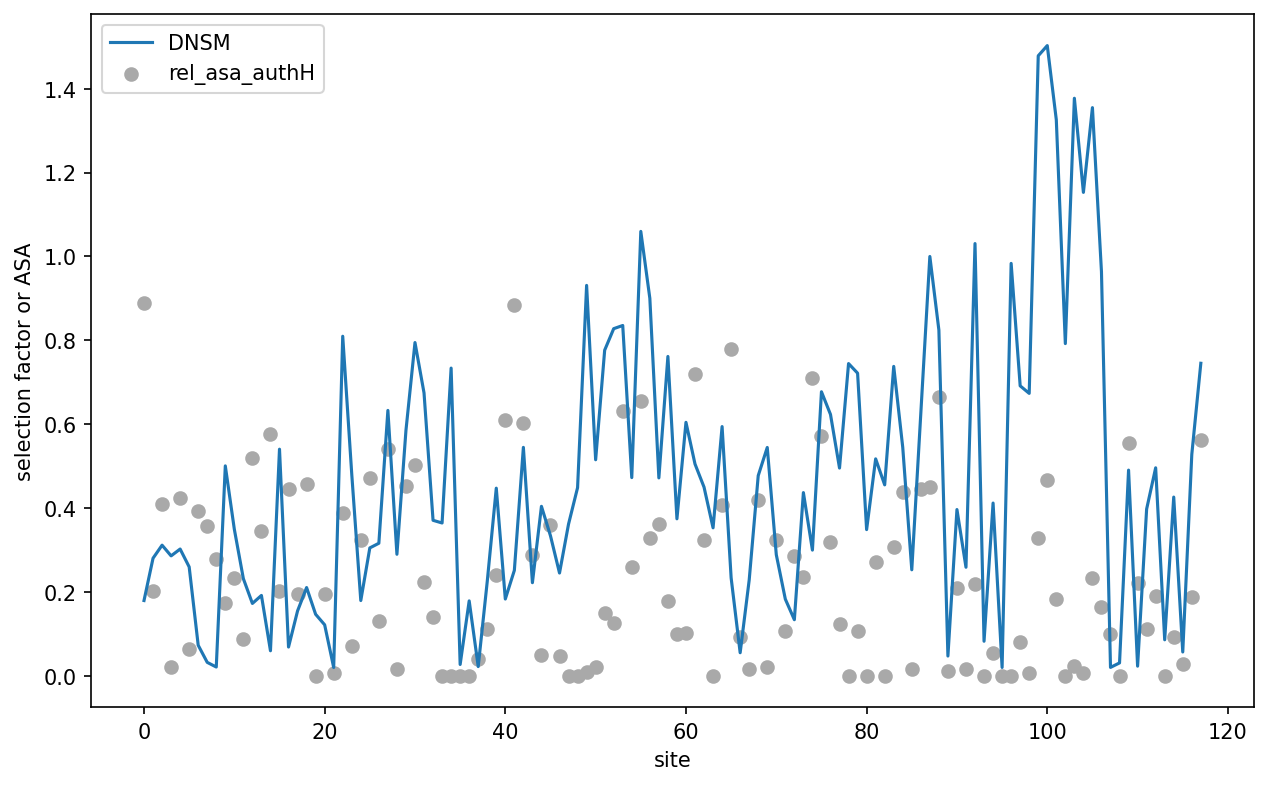

In [36]:
full_asa_compare_df = asa_df["rel_asa_authH"].to_frame()
full_asa_compare_df["DNSM"] = igh_2vxs_f

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(full_asa_compare_df.index, full_asa_compare_df['DNSM'], label='DNSM')
plt.scatter(full_asa_compare_df.index, full_asa_compare_df['rel_asa_authH'], label='rel_asa_authH', color='darkgray')

plt.xlabel('site')
plt.ylabel('selection factor or ASA')
plt.legend()

# Show the plot
plt.show()
